In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
import ta
import warnings
warnings.filterwarnings('ignore')

## importing dataset

In [408]:
df = pd.read_csv('./data//BTC-USD(1).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [409]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2747, 7), (2747, 7))

In [410]:
df = df.drop(['Adj Close'], axis=1)

## Feature Engineering


In [411]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')
df['Date'] = pd.to_datetime(df['Date']) 

df.head()


,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


In [412]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [413]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302978
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995


In [414]:
# Try different features see which helps
df['daily_return'] = df['Close'].pct_change()
df['ma_7'] = df['Close'].rolling(7).mean()  
df['close_t-1'] = df['Close'].shift(1)
df['close_t-2'] = df['Close'].shift(2)
df['open_t-1'] = df['Open'].shift(1)
df['volume_t-1'] = df['Volume'].shift(1)
df['rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df['rolling_std_3'] = df['Close'].rolling(window=3).std()

df['pct_change_close'] = df['Close'].pct_change()
df['pct_change_open'] = df['Open'].pct_change()
df['pct_change_high'] = df['High'].pct_change()
df['pct_change_low'] = df['Low'].pct_change()

df['body'] = abs(df['Close'] - df['Open'])
df['upper_shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

df['trend_day2_vs_day1'] = np.where(df['Close'].shift(2) > df['Close'].shift(3), 1, 0)
df['trend_day3_vs_day2'] = np.where(df['Close'].shift(1) > df['Close'].shift(2), 1, 0)

#df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df['target'] = np.where((df['Close'].shift(-1) - df['Close']) > 0.005 * df['Close'], 1, 0) # increase over 0.5%

df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['macd'] = ta.trend.MACD(df['Close']).macd()
df['ema_12'] = ta.trend.EMAIndicator(df['Close'], window=12).ema_indicator()
df['ema_26'] = ta.trend.EMAIndicator(df['Close'], window=26).ema_indicator()

df['price_volume_ratio'] = df['Close'] / df['Volume'].rolling(7).mean()  
df['volatility_ratio'] = df['High'] - df['Low'] / df['Close']  
df['obv_ema'] = ta.trend.EMAIndicator(ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume(), window=14).ema_indicator()  # OBV momentum
df['vwap'] = ta.volume.VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume']).volume_weighted_average_price()  # Institutional activity

df['rsi_lag_7'] = df['rsi'].shift(7)  
df['macd_cross'] = (df['macd'] > 0).astype(int) - (df['macd'] < 0).astype(int)  


df.dropna(inplace=True)
df.head(10)

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,...,rsi,macd,ema_12,ema_26,price_volume_ratio,volatility_ratio,obv_ema,vwap,rsi_lag_7,macd_cross
25,2014-10-12,362.605988,379.433014,356.144012,378.549011,17552800,2014,10,12,0,...,48.311573,-17.904763,363.683813,381.588575,0.000008,378.492201,-9.988341e+07,350.248116,19.609190,-1
26,2014-10-13,377.920990,397.226013,368.897003,390.414001,35221400,2014,10,13,0,...,52.739806,-14.446161,367.796149,382.242311,0.000009,396.281126,-8.757649e+07,350.815213,25.082402,-1
27,2014-10-14,391.691986,411.697998,391.324005,400.869995,38491500,2014,10,14,0,...,56.293392,-10.737706,372.884433,383.622139,0.000010,410.721811,-7.177829e+07,352.094586,28.431847,-1
28,2014-10-15,400.954987,402.226990,388.765991,394.773010,25267100,2014,10,15,0,...,53.755190,-8.196223,376.251907,384.448130,0.000011,401.242206,-6.145546e+07,352.448622,36.780527,-1
29,2014-10-16,394.518005,398.807007,373.070007,382.556000,26990000,2014,10,16,0,...,48.988694,-7.086205,377.221767,384.307972,0.000013,397.831803,-5.610768e+07,352.958560,42.033997,-1
30,2014-10-17,382.756012,385.477997,375.389008,383.757996,13600700,2014,10,17,0,...,49.463490,-6.039892,378.227341,384.267233,0.000016,384.499805,-4.965951e+07,352.984695,40.982820,-1
31,2014-10-18,383.976013,395.157990,378.971008,391.441986,11416800,2014,10,18,0,...,52.506761,-4.538333,380.260363,384.798696,0.000016,394.189849,-4.254885e+07,354.776473,41.319059,-1
32,2014-10-19,391.253998,393.938995,386.457001,389.545990,5914570,2014,10,19,0,...,51.679788,-3.461426,381.688921,385.150347,0.000017,392.946925,-3.717489e+07,361.479444,48.311573,-1
33,2014-10-20,389.230988,390.084015,378.252014,382.845001,16419000,2014,10,20,0,...,48.756987,-3.112802,381.866780,384.979581,0.000019,389.096012,-3.470666e+07,368.769530,52.739806,-1
34,2014-10-21,382.420990,392.645996,380.834015,386.475006,14188900,2014,10,21,0,...,50.393685,-2.514616,382.575737,385.090353,0.000024,391.660592,-3.067568e+07,373.924123,56.293392,-1


In [415]:
print("Class Distribution:\n", df['target'].value_counts())

Class Distribution:
 target
0    1536
1    1186
Name: count, dtype: int64


In [416]:

features = df[['low-high', 'open-close']]

target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
split_index = int(len(features) * 0.7)
X_train = features[:split_index]
X_valid = features[split_index:]
Y_train = target[:split_index]
Y_valid = target[split_index:]

## Model Development and Evaluation

In [417]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.4834761321909425

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.37      0.44       452
           1       0.44      0.62      0.52       365

    accuracy                           0.48       817
   macro avg       0.50      0.50      0.48       817
weighted avg       0.50      0.48      0.48       817



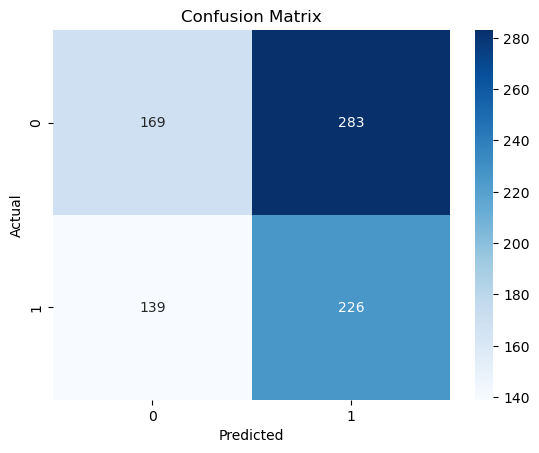

In [418]:
#model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.3)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)
print("Accuracy:", accuracy_score(Y_valid, Y_pred))

# Detailed metrics
print("\nClassification Report:\n", classification_report(Y_valid, Y_pred))

# Confusion matrix
cm = confusion_matrix(Y_valid, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

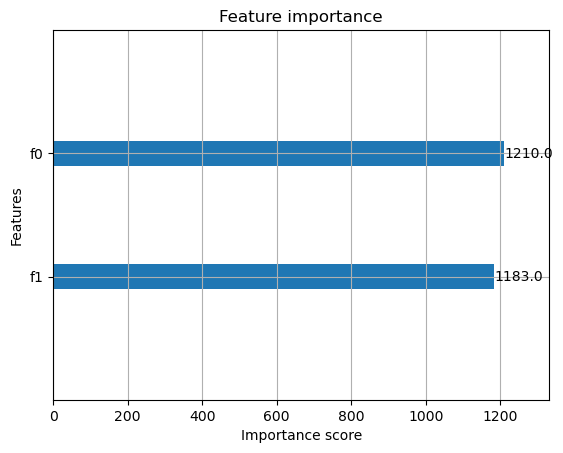

In [419]:
from xgboost import plot_importance
plot_importance(model)

In [341]:
# (as a sanity baseline)
models = [LogisticRegression(), SVC(kernel='poly', probability=True)]

for i in range(2):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()


LogisticRegression() : 
Training Accuracy :  0.5803111137079702
Validation Accuracy :  0.5213480421869318

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.6432473673092396
Validation Accuracy :  0.49768759849678745



In [ ]:
split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index]
valid_df = df.iloc[split_index:]

# Add new features
features = [ 'pct_change_open', 'pct_change_high', 'pct_change_low', 'body', 'upper_shadow', 'lower_shadow', 'rsi', 'macd', 'ema_12','price_volume_ratio','rsi_lag_7']
target = 'target'

X_train = train_df[features]
Y_train = train_df[target]
X_valid = valid_df[features]
Y_valid = valid_df[target]

# Scale using training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [343]:
print(Y_train.value_counts(normalize=True))
print(Y_valid.value_counts(normalize=True))

target
0    0.569029
1    0.430971
Name: proportion, dtype: float64
target
0    0.553244
1    0.446756
Name: proportion, dtype: float64


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Convert data to DMatrix (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train_scaled, label=Y_train)
dvalid = xgb.DMatrix(X_valid_scaled, label=Y_valid)

# Initial model with early stopping
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=10
)

# Hyperparameter tuning 
param_grid = {
    'max_depth': [12],         
    'learning_rate': [0.01],  
    'gamma': [0],                  
    'reg_lambda': [0.1, 0.5],     
    'subsample': [0.7, 0.8],          
    'colsample_bytree': [0.6],       
    'scale_pos_weight': [1.3]      
}
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)
'''
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3
)
grid_search.fit(X_train_scaled, Y_train)
best_model = grid_search.best_estimator_
'''
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=100, cv=3, 
                                   scoring='roc_auc', verbose=2, random_state=42)
random_search.fit(X_train_scaled, Y_train)

best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
base_learners = [
    ('xgb', xgb.XGBClassifier(objective='binary:logistic')),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]

stacked_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stacked_model.fit(X_train_scaled, Y_train)

stacked_preds = stacked_model.predict(X_valid_scaled)

[0]	eval-logloss:0.69013


[10]	eval-logloss:0.69069
[20]	eval-logloss:0.69917
[30]	eval-logloss:0.71312
[40]	eval-logloss:0.72208
[50]	eval-logloss:0.73836
[57]	eval-logloss:0.74132
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=12, reg_lambda=0.1, scale_pos_weight=1.3, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=12, reg_lambda=0.1, scale_pos_weight=1.3, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=12, reg_lambda=0.1, scale_pos_weight=1.3, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=12, reg_lambda=0.1, scale_pos_weight=1.3, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=12, reg_lambda=0.1, scale_pos_weight=1.3, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(
    best_model,
    method='isotonic',  
    cv=3
)
calibrator.fit(X_train_scaled, Y_train)
y_probs_calibrated = calibrator.predict_proba(X_valid_scaled)[:, 1]

#plt.hist(y_probs_calibrated, bins=20)
#plt.show()

In [404]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=tscv  
)

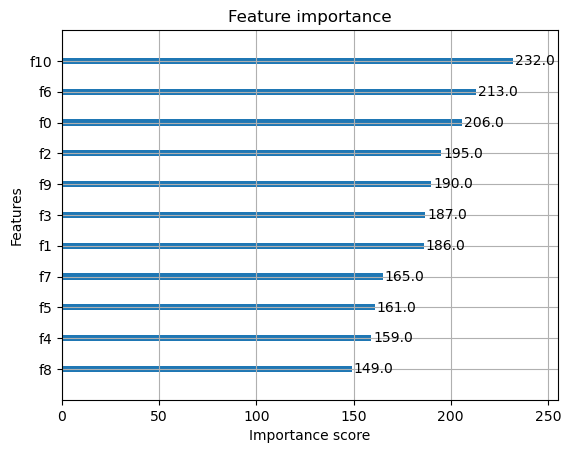

In [405]:
xgb.plot_importance(model)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.61       452
           1       0.45      0.33      0.38       365

    accuracy                           0.52       817
   macro avg       0.50      0.50      0.49       817
weighted avg       0.50      0.52      0.50       817


AUC-ROC: 0.5138


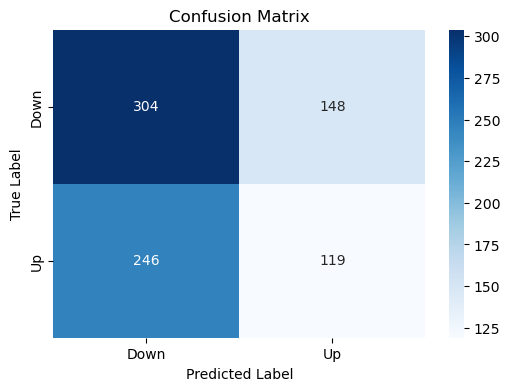

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds = best_model.predict(X_valid_scaled)
print("Classification Report:")
print(classification_report(Y_valid, preds))
print(f"\nAUC-ROC: {roc_auc_score(Y_valid, best_model.predict_proba(X_valid_scaled)[:,1]):.4f}")

cm = confusion_matrix(Y_valid, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], 
            yticklabels=['Down', 'Up'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()